# Ridge Regression Assignment


Let's look at a synthetic dataset consisting of 30 points drawn from $y = \cos(4x)$:

In [4]:
import turicreate
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

Create random values for x in interval [0,1)

In [55]:
random.seed(98103)
n = 30
x = turicreate.SArray([random.random() for i in range(n)]).sort()
print(x)

[0.03957894495006575, 0.04156809967912256, 0.0724319480800758, 0.1502890446221763, 0.16133414450223427, 0.19195631279497838, 0.23283391714465285, 0.25990098016580054, 0.3801458148686865, 0.432444723507992, 0.47056698189428126, 0.4714946037956341, 0.47870640066103853, 0.49053553924712967, 0.5467800590828905, 0.5696803579782542, 0.6079324536462045, 0.6202375373443129, 0.630093133764472, 0.6450096693254694, 0.6467576040906915, 0.6990897790220533, 0.7902450464374043, 0.8103846511814395, 0.829320894073608, 0.8501115576007019, 0.8863684369527574, 0.8911410794245727, 0.9043884813966695, 0.9244858666003654]


Compute y

In [56]:
y = x.apply(lambda x: math.sin(4 * x))
print(y)

[0.15765527330715118, 0.16550731513895361, 0.28569137317201587, 0.5655963310738573, 0.6014673638641537, 0.6945723182799316, 0.8024177336626097, 0.8622036562183355, 0.9987395887969133, 0.9873888679370947, 0.9518836143289069, 0.9507399491702666, 0.9414033048470645, 0.9243965533386744, 0.8160088904398481, 0.759712729130455, 0.6517297472208435, 0.6136242987242347, 0.5820277559882728, 0.5325021703779891, 0.5265711949509843, 0.3384164444332101, -0.019386317630007324, -0.09977963765619023, -0.17478846590569042, -0.25597249131754973, -0.3929901249560022, -0.4104720422761508, -0.4581930879372578, -0.5280908755021222]


Add random Gaussian noise to y

In [58]:
random.seed(1)
e = turicreate.SArray([random.gauss(0, 1.0/3.0) for i in range(n)])
y = y + e
print(y)

[1.0164451087441262, 1.1318043876054675, 0.32991524579752385, 0.055900563759436195, -0.12664811287194055, 0.7154619961677428, 0.12101562032202784, -0.0956826405166844, 1.1316142397860827, 1.0763052710428314, 1.3161958145543946, 0.3414259866800582, 0.9447401605981127, 0.8812353797568826, -0.18787711040064625, 1.1183775149044775, 0.8655371478867423, 2.206365660884692, 0.7173405408615824, 0.4360339649347087, 1.3484093116369333, 0.4709439432288271, 0.5866343664721321, -0.34347581514453474, -0.029340590331968786, 0.4268866276737956, 0.07117455667930545, -0.3248238765209132, -1.1797317710012876, -0.23127636059475654]


### Put data into an SFrame to manipulate later

In [59]:
data = turicreate.SFrame({'X1': x, 'Y': y})
print(data)

+---------------------+----------------------+
|          X1         |          Y           |
+---------------------+----------------------+
| 0.03957894495006575 |  1.0164451087441262  |
| 0.04156809967912256 |  1.1318043876054675  |
|  0.0724319480800758 | 0.32991524579752385  |
|  0.1502890446221763 | 0.055900563759436195 |
| 0.16133414450223427 | -0.12664811287194055 |
| 0.19195631279497838 |  0.7154619961677428  |
| 0.23283391714465285 | 0.12101562032202784  |
| 0.25990098016580054 | -0.0956826405166844  |
|  0.3801458148686865 |  1.1316142397860827  |
|  0.432444723507992  |  1.0763052710428314  |
+---------------------+----------------------+
[30 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


### Create a function to plot the data, since we'll do it many times

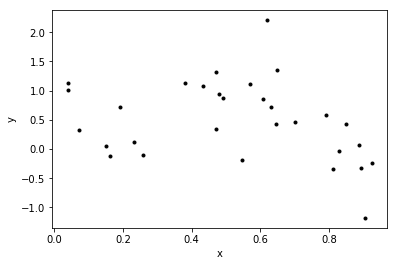

In [60]:
def plot_data(data):
    plt.plot(data['X1'], data['Y'], 'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

## Define some useful polynomial regression functions

Define and test a function to create our features for a polynomial regression model of any degree:

In [20]:
def polynomial_features(data, deg):
    data_copy = data.copy()
    for i in range(1, deg):
        data_copy['X' + str(i + 1)] = data_copy['X' + str(i)] * data_copy['X1']
    return data_copy

# Example: Adding columns for x^2 and x^3
polynomial_features(data, 3)

X1,Y,X2,X3
0.03957894495006575,0.15765527330715118,0.0015664928833603355,6.20001355951885e-05
0.04156809967912256,0.16550731513895361,0.0017279069109334693,7.18258067099272e-05
0.0724319480800758,0.28569137317201587,0.0052463871026747965,0.0003800060382289202
0.1502890446221763,0.5655963310738573,0.022586796933446496,0.003394548132202775
0.16133414450223427,0.6014673638641537,0.026028706182267807,0.004199319044416193
0.19195631279497838,0.6945723182799316,0.03684722602184358,0.007073057643876273
0.23283391714465285,0.8024177336626097,0.054211632972923064,0.012622306859893899
0.25990098016580054,0.8622036562183355,0.06754851949114385,0.01755592642449697
0.3801458148686865,0.9987395887969133,0.14451084056217767,0.05493519124286786
0.432444723507992,0.9873888679370947,0.18700843888990365,0.0808708126494056


Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [61]:
def polynomial_regression(data, deg):
    model = turicreate.linear_regression.create(polynomial_features(data, deg),
                                                target='Y',
                                                l2_penalty=0.,
                                                l1_penalty=0.,
                                                validation_set=None,
                                                verbose=False)    
    
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [38]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coefficients['value']) - 1

    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = turicreate.SFrame({'X1': [i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred, deg))

    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-',  label='degree {} fit'.format(deg))
    plt.legend(loc='upper left')
    plt.axis([0, 1, -1.5, 2])
   

Create a function that prints the polynomial coefficients in a pretty way :)

In [43]:
def print_coefficients(model):  
    # Get the degree of the polynomial
    deg = len(model.coefficients['value']) - 1

    # Get learned parameters as a list
    beta = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print('Learned polynomial for degree {}:'.format(deg))
    beta.reverse()
    print(numpy.poly1d(beta))
 

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [41]:
model = polynomial_regression(data, deg=2)

print coefficents of the degree-2 modle and inspect learned parameters

In [44]:
print_coefficients(model)

Learned polynomial for degree 2:
        2
-5.733 x + 4.585 x + 0.01624


Form and plot our predictions along a grid of x values:

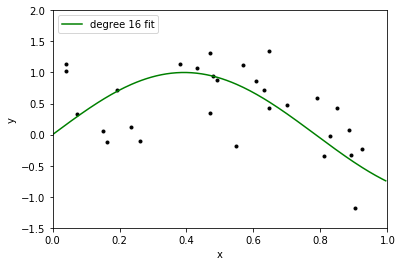

In [62]:
plot_poly_predictions(data, model)

## Fit a degree-4 polynomial

Learned polynomial for degree 4:
       4         3         2
39.18 x - 94.19 x + 70.35 x - 17.72 x + 1.555


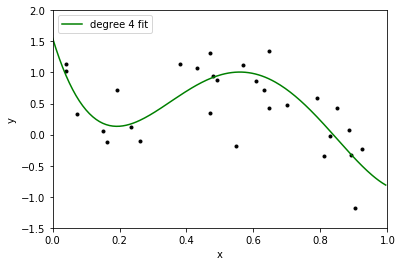

In [63]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data, model)

## Fit a degree-16 polynomial

In [64]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:
           16             15             14             13
5.285e+06 x  - 2.072e+07 x  + 2.302e+07 x  + 1.397e+07 x 
              12             11             10             9
 - 5.318e+07 x  + 4.296e+07 x  - 1.036e+07 x  + 7.917e+06 x
              8             7            6             5            4
 - 2.632e+07 x + 3.074e+07 x - 1.89e+07 x + 6.993e+06 x - 1.61e+06 x
              3             2
 + 2.261e+05 x - 1.809e+04 x + 710.8 x - 9.401


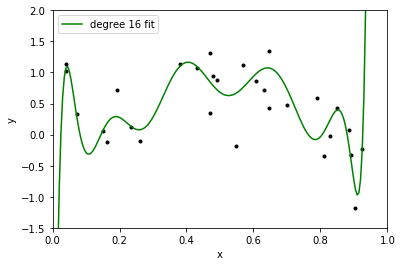

In [65]:
plot_poly_predictions(data,model)

# Ridge Regression

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [69]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = turicreate.linear_regression.create(polynomial_features(data, deg),
                                                target='Y', l2_penalty=l2_penalty,
                                                validation_set=None, verbose=False)
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

l2_penalty=1e-25

In [71]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

Learned polynomial for degree 16:
           16             15             14             13
5.285e+06 x  - 2.072e+07 x  + 2.302e+07 x  + 1.397e+07 x 
              12             11             10             9
 - 5.318e+07 x  + 4.296e+07 x  - 1.036e+07 x  + 7.917e+06 x
              8             7            6             5            4
 - 2.632e+07 x + 3.074e+07 x - 1.89e+07 x + 6.993e+06 x - 1.61e+06 x
              3             2
 + 2.261e+05 x - 1.809e+04 x + 710.8 x - 9.401


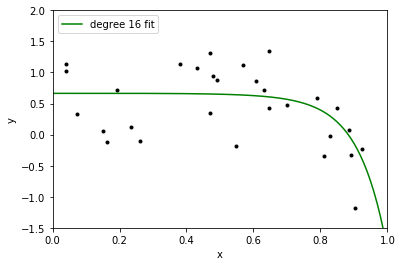

In [75]:
plot_poly_predictions(data, model)

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength
l2_penalty=100

In [74]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:
       16          15          14          13          12          11
-0.33 x  - 0.3041 x  - 0.2794 x  - 0.2557 x  - 0.2329 x  - 0.2108 x 
           10          9          8          7          6           5
 - 0.1893 x  - 0.1681 x - 0.1469 x - 0.1254 x - 0.1033 x - 0.08014 x
            4           3            2
 - 0.05575 x - 0.03075 x - 0.008165 x + 0.004053 x + 0.6641


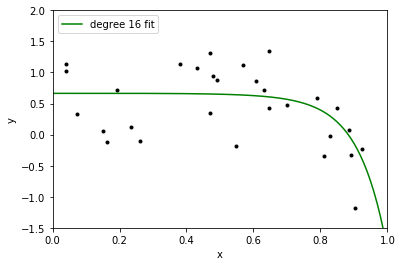

In [76]:
plot_poly_predictions(data,model)

## find fits for a sequence of increasing lambda values, for each fit print coefficients and plot predictions

lambda = 1e-25
Learned polynomial for degree 16:
           16             15             14             13
5.285e+06 x  - 2.072e+07 x  + 2.302e+07 x  + 1.397e+07 x 
              12             11             10             9
 - 5.318e+07 x  + 4.296e+07 x  - 1.036e+07 x  + 7.917e+06 x
              8             7            6             5            4
 - 2.632e+07 x + 3.074e+07 x - 1.89e+07 x + 6.993e+06 x - 1.61e+06 x
              3             2
 + 2.261e+05 x - 1.809e+04 x + 710.8 x - 9.401


lambda = 1e-10
Learned polynomial for degree 16:
           16             15             14             13
9.949e+04 x  - 1.564e+05 x  - 4.532e+04 x  + 7.899e+04 x 
              12        11             10             9             8
 + 8.731e+04 x  + 6152 x  - 6.665e+04 x  - 5.572e+04 x + 2.065e+04 x
              7        6             5             4             3
 + 5.925e+04 x - 2880 x - 5.195e+04 x + 3.679e+04 x - 1.118e+04 x
         2
 + 1732 x - 134.4 x + 4.318


lambda = 1e-06
L

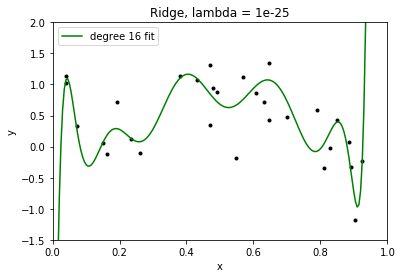

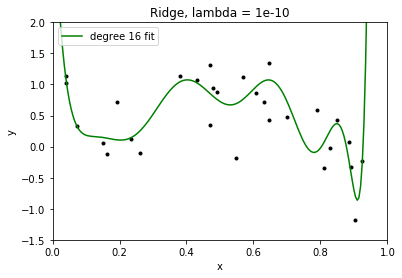

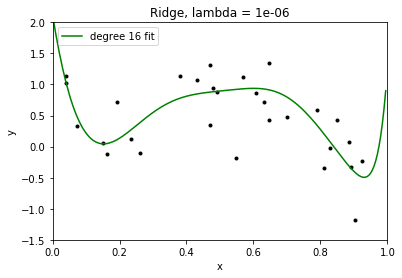

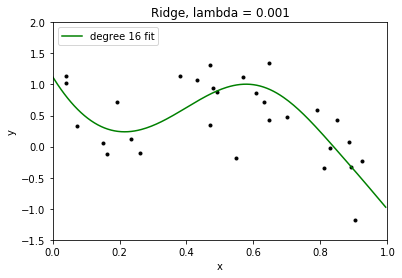

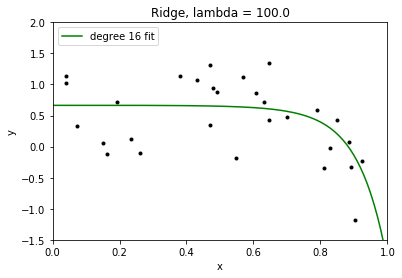

In [81]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print('lambda = ' + str(l2_penalty))
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('Ridge, lambda = ' + str(l2_penalty))

## implement Leave one out validation method.

In [84]:
import turicreate_cross_validation.cross_validation as tcv

# LOO cross validation -- return the average MSE and the best l2 penalty value
def loo(data, deg, l2_penalty_values):
    data = polynomial_features(data, deg)

    num_folds = len(data)
    shuffeled_data = tcv.shuffle_sframe(data, 98103)
    folds_iterator = tcv.KFold(shuffeled_data, num_folds)
    folds = [f for f in folds_iterator]

    l2_penalty_mse = []
    min_mse = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            model = turicreate.linear_regression.create(train_set, target='Y',
                                                        l2_penalty=l2_penalty,
                                                        validation_set=None,
                                                        verbose=False)
            y_test_predicted = model.predict(validation_set)
            next_mse += ((y_test_predicted - validation_set['Y'])**2).sum()
        next_mse /= num_folds
        l2_penalty_mse.append(next_mse)

        if min_mse is None or next_mse < min_mse:
            best_l2_penalty = l2_penalty
    return l2_penalty_mse, best_l2_penalty

Run LOO cross validation for "num" values of lambda, on a log scale for degree-16 polynomial

In [94]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse,best_l2_penalty = loo(data, 16, l2_penalty_values)
print(l2_penalty_mse)
print(best_l2_penalty)

[0.5045294325807032, 0.3985473373980727, 0.3523897633040436, 0.35919745238665546, 0.3586287526228881, 0.46755361206418006, 0.4808567608086335, 0.4812555649227093, 0.48126668553876495, 0.4812669949948737]
10000000000.0


Plot results of estimating LOO for each value of lambda

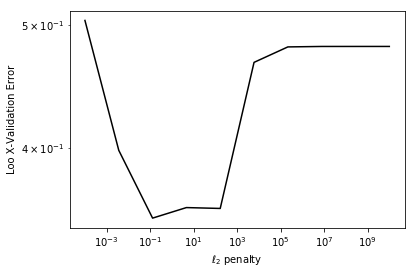

In [96]:
plt.plot(l2_penalty_values, l2_penalty_mse, 'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('Loo X-Validation Error')
plt.xscale('log')
plt.yscale('log')

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [ ]:
best_l2_penalty

In [ ]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

In [ ]:
plot_poly_predictions(data,model)

Compare with linear regression degree-16 polynominal. How different are the coefficiets?

Learned polynomial for degree 16:
           16             15             14             13
5.285e+06 x  - 2.072e+07 x  + 2.302e+07 x  + 1.397e+07 x 
              12             11             10             9
 - 5.318e+07 x  + 4.296e+07 x  - 1.036e+07 x  + 7.917e+06 x
              8             7            6             5            4
 - 2.632e+07 x + 3.074e+07 x - 1.89e+07 x + 6.993e+06 x - 1.61e+06 x
              3             2
 + 2.261e+05 x - 1.809e+04 x + 710.8 x - 9.401


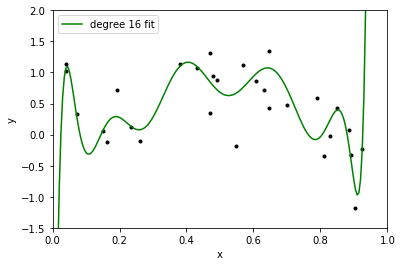

In [97]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)
plot_poly_predictions(data,model)

Run LOO cross validation for "num" values of lambda, on a log scale for degree-16 polynomial

Plot results of estimating LOO for each value of lambda

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit for degree-4 polynomial 

Learned polynomial for degree 4:
            4             3             2
-2.557e-09 x - 1.819e-09 x - 1.086e-09 x - 4.459e-10 x + 0.493


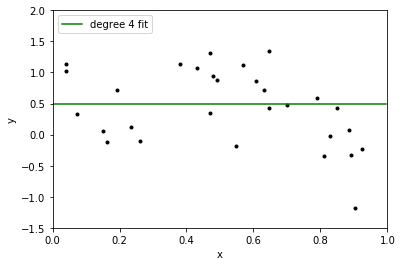

In [98]:
model = polynomial_ridge_regression(data, deg=4, l2_penalty=best_l2_penalty)
print_coefficients(model)
plot_poly_predictions(data,model)

Compare with linear regression degree-4 polynominal. How different are the coefficiets?


Learned polynomial for degree 4:
       4         3         2
39.18 x - 94.19 x + 70.35 x - 17.72 x + 1.555


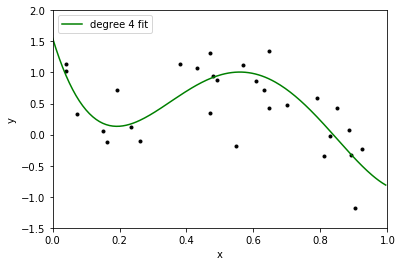

In [99]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)